# Final Project: Image Denoiser Extended

Brennan McFarland  
bfm21

Here I will increase the effectiveness of the image denoiser from Assignment 2 to perform more accurate denoising on video.  I plan to do this by calculating pixel intensity not just on neighboring pixels in the same frame but their values in the previous and/or next few frames as well.  For simplicity and ease of demonstration, I will apply my denoiser to a few consecutive frames of video.

### Loading the Frames

For the purposes of data processing, we can treat the sucession of frames as just another (in this case the outermost) dimension of our pixel array:

In [1]:
num_images = 6
nratio = .1

In [2]:
def showimgs(imgs, ncol=3):
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(imgs) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img, title in zip(range(len(imgs)), imgs, range(num_images)):
        ax = plt.subplot(subindex + i + 1)
        ax.set_title(title)
        plt.imshow(img, cmap='gray')

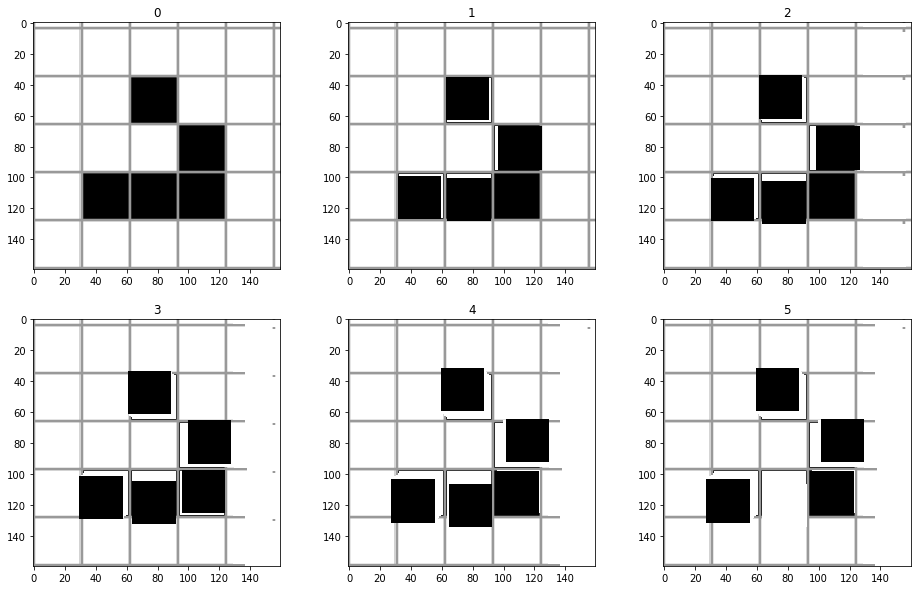

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d
from skimage import io

loaded_imgs = [None]*num_images

for i in range(num_images):
    loaded_imgs[i] = io.imread('images/0'+str(i+1)+'.png', as_grey=True)
org_imgs = np.array(loaded_imgs)
showimgs(org_imgs)

black_value, white_value = -1.0, 1.0

### Adding Noise

Since we treat time just as another array dimension, adding noise is just a slight generalization from the previous assignment to work in three dimensions instead of two:

In [4]:
def addnoise(org_imgs, nratio=0.1):
    nsy_imgs = org_imgs.copy()
    index = np.random.rand(*nsy_imgs.shape)
    # flip pixels to generate noisy image
    for t in range(len(nsy_imgs)): # t for time, ie the frame number
        for r in range(len(nsy_imgs[t])):
            for c in range(len(nsy_imgs[t][r])):
                if index[t][r][c] < nratio:
                    nsy_imgs[t][r][c] = np.random.uniform(0.0, 1.0)
    return nsy_imgs

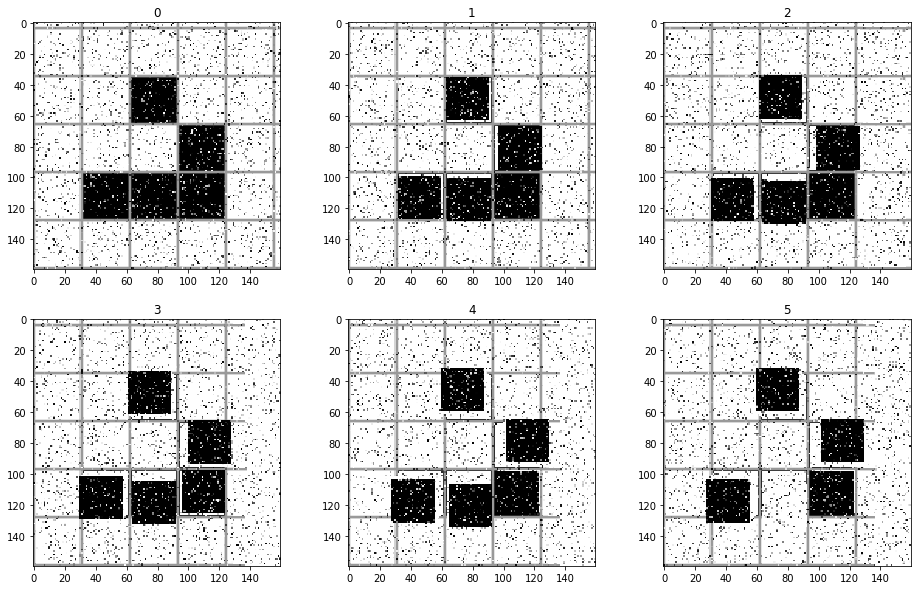

In [5]:
nsy_imgs = addnoise(org_imgs, nratio = 0.1)
showimgs(nsy_imgs)

### Probability/Energy Function

I will be using the extended energy function from before as it yields the best results and protects the edges of the images:
$$\begin{array}{rcl}
E(X,Y) & = & -\alpha \sum\limits_{i} max_{j}(x_iT_{\alpha}^{j}(x_i)) - 
					\sigma \sum\limits_{i} max_{j}(x_iT_{\sigma}^{j}(x_i)) \\
       &   & \quad - \sum\limits_{i} x_i [\beta T_{\beta}(x_i) + \gamma T_{\gamma}(x_i) +
					\phi T_{\phi}(x_i)] - \eta \sum\limits_{i} x_i y_i
\end{array}$$
However, since we are also taking into account multiple frames, the alpha and other parameters now extend over the full image sequence.  In the future, I would l

### Solving the Model

Since in the Assignment 2 I already showed that simulated annealing led to subpar results, here I will only be applying gradient descent:  The normalizing and denormalizing functions require some modification to work in three dimensions, and of course the gradient descent must take all the frames into account:

In [7]:
# map greyscale values from [-1, 1] to [0, 1]
def normalize(imgs):
    for t in range(len(imgs)):
        for r in range(len(imgs[t])):
            for c in range(len(imgs[t][r])):
                imgs[t][r][c] = (imgs[t][r][c]+1.0)/2.0

In [8]:
# map greyscale values from [0, 1] to [-1, 1]
def denormalize(imgs):
    for t in range(len(imgs)):
        for r in range(len(imgs[t])):
            for c in range(len(imgs[t][r])):
                imgs[t][r][c] = imgs[t][r][c]*2.0-1.0

In [9]:
showproc_steps = 10
def denoise(nsy_imgs, efunc, algorithm, showproc = False):
    if showproc:
        showimgs(nsy_imgs)
    return algorithm(nsy_imgs, efunc, showproc)

In [11]:
def gradient_descent(nsy_imgs, efunc, showproc = False):
    # initialize recoverred image as noisy image
    rec_imgs = nsy_imgs.copy()
    denormalize(nsy_imgs)
    denormalize(rec_imgs)
    # calculate energy function and its gradients
    E, dE = efunc(rec_imgs, nsy_imgs)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by setting pixels to random values, which could decrease energy function
        rec_imgs[dE < 0] = np.random.uniform(black_value, white_value)
        for t in range(len(rec_imgs)):
            for r in range(len(rec_imgs[t])):
                for c in range(len(rec_imgs[t][r])):
                    if dE[t][r][c] < 0:
                        rec_imgs[t][r][c] = np.random.uniform(black_value, white_value)
        # calculate energy function with revised image
        [E, dE] = efunc(rec_imgs, nsy_imgs)
        # update iteration count
        i += 1
        # show revised image
        if showproc and i%showproc_steps == 0:
            display_intermediate_image('Recovered Image (Iter-%d)' % i)
    normalize(nsy_imgs)
    normalize(rec_imgs)
    # return recovered image
    return rec_imgs

Since most pixels of the image sequence remain static from frame to frame, I use essentially the same filters generalized across frames for denoising to bias the filters against pixel value change:

In [57]:
from scipy.ndimage.filters import convolve
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]]]*num_images)
    # template beta
    Tb = np.asarray([[[0, 1, 0], [1, 0, 1], [0, 1, 0]]]*num_images)
    # template gamma
    Tr = np.asarray([[[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]]]*num_images)
    # template phi
    Tp = np.asarray([[[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]]]*num_images)
    # template sigma
    Ts = np.asarray([[[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]]]*num_images)
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * convolve(hidden, T))
    # generate parameter matrix beta
    matB = convolve(hidden, Tb)
    # generate parameter matrix gamma
    matR = convolve(hidden, Tr)
    # generate parameter matrix phi
    matP = convolve(hidden, Tp)
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * convolve(hidden, T))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

In [62]:
medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

Noisy:
Recovered:


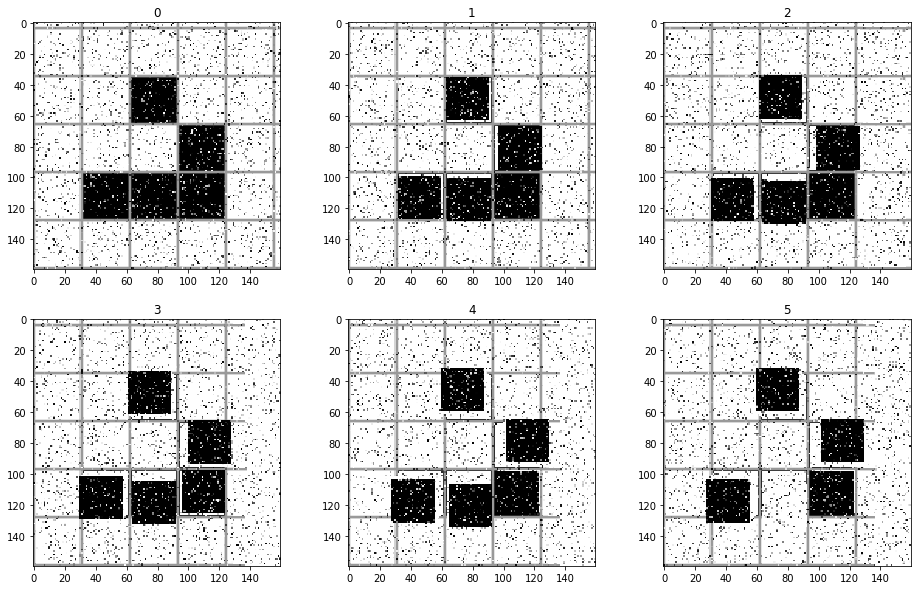

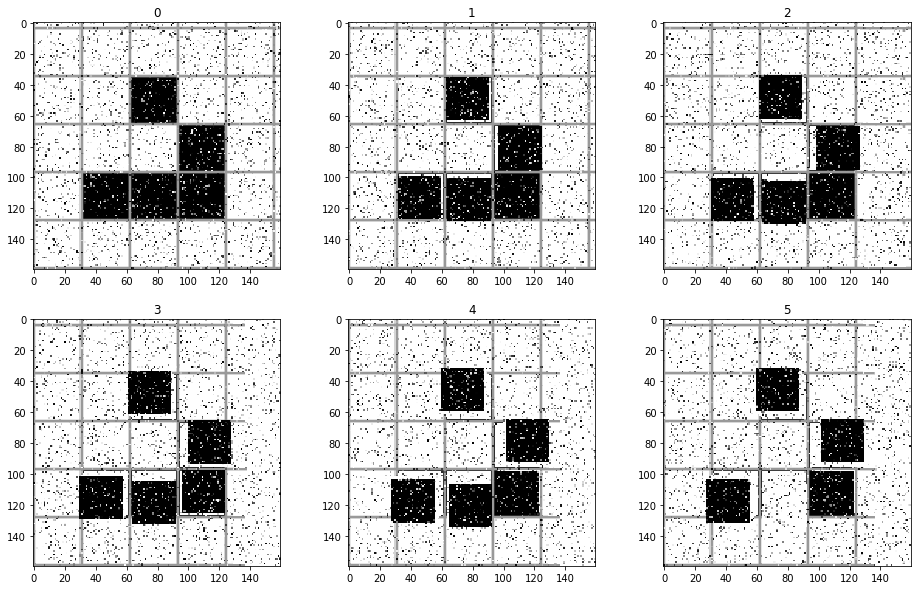

In [63]:
print("Noisy:")
showimgs(nsy_imgs)
rec_imgs = denoise(nsy_imgs, medFilterProtectS, gradient_descent)
print("Recovered:")
showimgs(rec_imgs)

Unfortunately, the results are rather unimpressive and much worse than denoising a single frame.  I may attempt further exploration of tuning the energy function and filter parameters in an attempt to improve the denoising process.